# Get started with Pytorch

**What are tensors, how to create them, what to do with them?**

An array of numbers.

tensor1 = torch.tensor([[0., -2., 3.], [12., 5., 1.]])

Add, multiply, matrix multiplication, transpose, reshape with view, sum, mean, max... and convert them back to numpy array.


**How to make use of GPU support**

device = "cuda" if torch.cuda.is_available() else "cpu"

**How to use automatic differentiation**

x = torch.tensor(3., requires_grad=True)

Do computation: y = ...

y.backward()

x.grad

# Imports


In [1]:
# Imports
import torch
import numpy as np
from matplotlib import pyplot as plt

from time import perf_counter
from typing import Tuple, Optional, Dict


# File System Paths
from pathlib import Path

# Downloading the MNIST data - sending HTTP requests
import requests

# Loading from binary files
import pickle

# Opening zips
import gzip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is", device)

Device is cpu


# Loading MNIST Data and some Statistics

In [2]:
# Imports
import torch
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Getting the Data of MNIST dataset.
# https://www.google.com/url?q=https%3A%2F%2Fpytorch.org%2Ftutorials%2Fbeginner%2Fnn_tutorial.html

# File System Paths
from pathlib import Path

# Downloading the MNIST data - sending HTTP requests
import requests

# Base Directory Path
DATA_PATH = Path("data")

# Subdirectory Path
PATH = DATA_PATH / "mnist"

# Creates the Path Directories if they do not exist yet
PATH.mkdir(parents=True, exist_ok=True)

# Location of MNIST Dataset
URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

# Check if it exists locally and downloades it - writes in binary ("wb")
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

# Loading from binary files
import pickle

# Opening zips
import gzip

# Opens the MNIST zip
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        # Unpacks data x and y train, validation and test sets
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

In [4]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (50000, 784)
y_train shape: (50000,)
x_valid shape: (10000, 784)
y_valid shape: (10000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


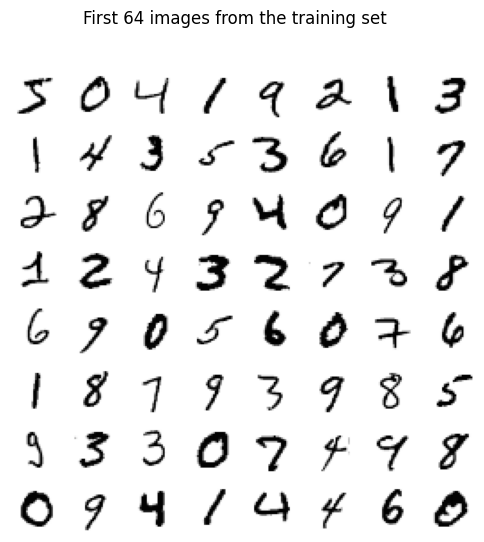

In [5]:
# Plot figure size 6 x 6 = 28
plt.figure(figsize=(6, 6))
# enumerate allows to index each entry, slicing x_train from 0 up to 64
for ind, img in enumerate(x_train[:64]):
    # 8 x 8 Plot, Subplots start at 1 not 0
    plt.subplot(8, 8, ind+1)
    # Image was flattened to 1D into 784, reshape to 28 x 28
    plt.imshow(x_train[ind].reshape((28, 28)), cmap="Greys")
    plt.axis("off")
plt.suptitle("First 64 images from the training set")
plt.show()

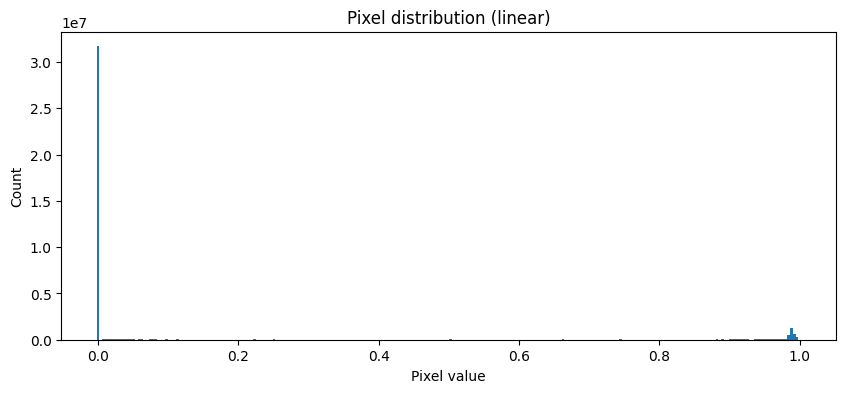

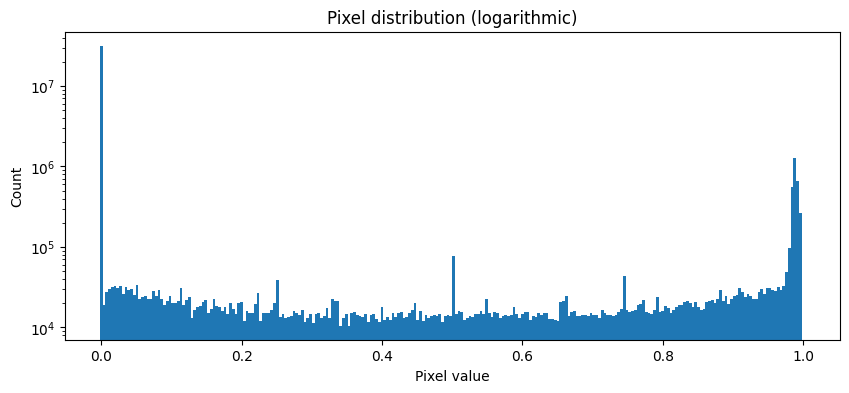

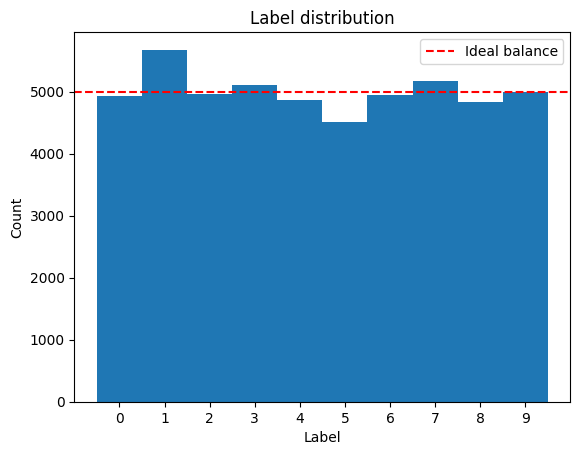

In [6]:
# What is this strange binning?
# MNIST is originally stored as 8bit integers in the range [0, 255].
# the data here has been preprocessed to floats in the range [0, 1],
# but there are still only 256 unique values.
# So we create one bin per value.
# to actually center around a value, like 0, we need to create a bin like [-0.5, 0.5].
# so we do this until the top end, [254.5, 255.5] to get a bin for the value 255.
# then we divide by 255 to normalize to range [0, 1].
bins = np.arange(-0.5, 256.5, 1) / 255
plt.figure(figsize=(10, 4))
plt.hist(x_train.reshape(-1), bins=bins)
plt.title("Pixel distribution (linear)")
plt.xlabel("Pixel value")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(x_train.reshape(-1), bins=bins)
plt.yscale("log")
plt.title("Pixel distribution (logarithmic)")
plt.xlabel("Pixel value")
plt.ylabel("Count")
plt.show()

# now the labels
bins = np.arange(-0.5, 10.5, 1)
plt.hist(y_train, bins=bins)
plt.hlines(5000, -1, 10, colors="red", linestyles="dashed", label="Ideal balance")

plt.xticks(np.arange(10))
plt.xlim(-1, 10)
plt.title("Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.legend()
plt.show()

# Basic Linear Model

## Model Construction




In [7]:
# Model Class
class Model:
    # Initialize Model with Weights and Biases
    # Input Classes: 10
    # Input Features: 784 - each pixel
    def __init__(self):
        self.weights = torch.zeros(10, 784, requires_grad=True)
        self.bias = torch.zeros(10, requires_grad=True)
        # example to create random weights instead.
        # you NEED this for MLPs! for linear models, 0s are fine.
        # biases are usually fine to initialize with 0s even for MLPs.
        #self.weights = torch.distributions.Uniform(-0.01, 0.01).sample((10, 784))

    # Multiply Input with weights and bias to get output
    def forward(self, inputs: torch.tensor) -> torch.tensor:
        logits = inputs @ self.weights.transpose(0,1) + self.bias  # x @ y is equivalent to torch.matmul(x, y)
        return softmax(logits)

    # allows model() to be called to act as model.forward()
    def __call__(self, inputs: torch.tensor) -> torch.tensor:
        return self.forward(inputs)

In [8]:
# Turns Logits into Probabilities
def softmax(inputs: torch.tensor) -> torch.tensor:
    exponential = torch.exp(inputs)
    return exponential / exponential.sum(axis=-1, keepdims=True)

# Error / Loss Function - Comparing output with Labels
def cross_entropy(labels: torch.tensor,
                  outputs: torch.tensor) -> torch.tensor:
    labels_one_hot = one_hot(labels, num_classes=10)
    return -(labels_one_hot * torch.log(outputs)).sum(axis=-1).mean()

# Evaluation Metric
def accuracy(labels: torch.tensor,
             outputs: torch.tensor) -> torch.tensor:
    predictions = torch.argmax(outputs, axis=-1)
    matches = labels == predictions
    return matches.float().mean()

# one hot - only one class can be hot (1)
# Converts a list of labels into a one hot encoded tensor.
# Corresponding to number of classes where the class is a 1.
# [0, 2, 1]
# [ [1, 0, 0]
#   [0, 0, 2]
#   [0, 1, 0]]
# Needed for label comparisons/Loss functions
def one_hot(inputs: torch.tensor, num_classes: Optional[int] = None) -> torch.tensor:
    if num_classes is None:
        num_classes = inputs.max() + 1
    output = torch.zeros(inputs.shape[0], num_classes)
    output.scatter_(1, inputs.view(-1, 1), torch.ones(inputs.shape[0], 1))

    return output

## Model Training

In [9]:
def train_linear_model(model: Model,
                       training_data: Tuple[np.ndarray, np.ndarray],
                       validation_data: Tuple[np.ndarray, np.ndarray],
                       learning_rate: float,
                       batch_size: int,
                       n_epochs: int,
                       validation_frequency: int = 1,
                       verbose: bool = True) -> Dict[str, np.ndarray]:
    n_training_examples = len(training_data[0])
    batches_per_epoch = n_training_examples // batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    random_shuffling = np.arange(n_training_examples)

    train_input_tensor = torch.tensor(training_data[0])
    train_label_tensor = torch.tensor(training_data[1])
    valid_input_tensor = torch.tensor(validation_data[0])
    valid_label_tensor = torch.tensor(validation_data[1])

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")
        start_time = perf_counter()
        # every epoch we shuffle the data!
        np.random.shuffle(random_shuffling)  # this shuffles in place
        slice_index = 0
        shuffled_inputs = train_input_tensor[random_shuffling]
        shuffled_labels = train_label_tensor[random_shuffling]

        epoch_train_losses = []
        epoch_train_accuracies = []

        for batch_ind in range(batches_per_epoch):
            input_batch = shuffled_inputs[slice_index:slice_index+batch_size]
            label_batch = shuffled_labels[slice_index:slice_index+batch_size]
            # this is the core of model training!
            # all the other stuff is pretty much just providing data and recording metrics...
            # two lines "forward" to compute outputs and the loss
            output_batch = model(input_batch)
            batch_loss = cross_entropy(label_batch, output_batch)
            # and then backpropagate
            batch_loss.backward()
            with torch.no_grad():
                model.weights -= model.weights.grad * learning_rate
                model.bias -= model.bias.grad * learning_rate
                model.weights.grad.zero_()
                model.bias.grad.zero_()

            batch_accuracy = accuracy(label_batch, output_batch)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

            slice_index += batch_size
        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        with torch.no_grad():
            val_output = model(valid_input_tensor)
            val_loss = cross_entropy(valid_label_tensor, val_output)
            val_accuracy = accuracy(valid_label_tensor, val_output)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}

In [10]:
linear_model = Model()
metrics = train_linear_model(linear_model, (x_train, y_train), (x_valid, y_valid),
                             learning_rate=0.1, batch_size=128, n_epochs=15)

Running 15 epochs at 390 steps per epoch.
Starting epoch 1... Time taken: 0.42404089000000056 seconds
	Train/val loss: 0.6148210987830773 / 0.38368159532546997
	Train/val accuracy: 0.8558894230769231 / 0.9003999829292297
Starting epoch 2... Time taken: 0.30636578000000014 seconds
	Train/val loss: 0.39235526900260875 / 0.3371513783931732
	Train/val accuracy: 0.8938701923076923 / 0.9088000059127808
Starting epoch 3... Time taken: 0.26773129499999726 seconds
	Train/val loss: 0.3567439992076311 / 0.31779444217681885
	Train/val accuracy: 0.9010616987179487 / 0.9121999740600586
Starting epoch 4... Time taken: 0.27484035500000203 seconds
	Train/val loss: 0.3381266133525433 / 0.3059065341949463
	Train/val accuracy: 0.9061097756410257 / 0.9168000221252441
Starting epoch 5... Time taken: 0.2738227959999975 seconds
	Train/val loss: 0.326653604553296 / 0.29831361770629883
	Train/val accuracy: 0.9088541666666666 / 0.9174000024795532
Starting epoch 6... Time taken: 0.27691426200000535 seconds
	Train

## Model Evaluation

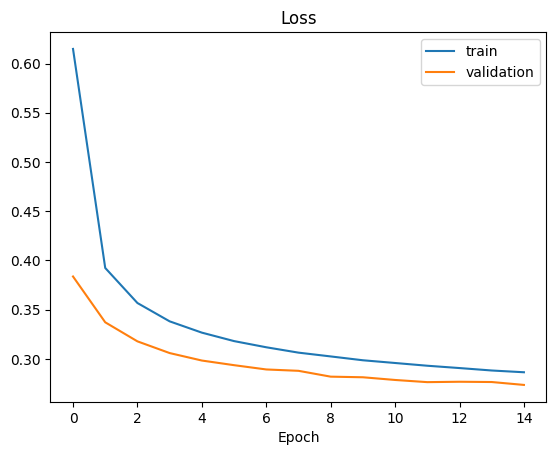

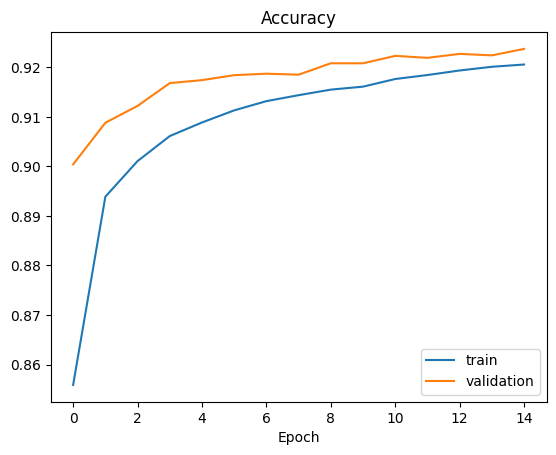

In [11]:
plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["val_loss"], label="validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(metrics["train_accuracy"], label="train")
plt.plot(metrics["val_accuracy"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [12]:
def confusion_matrix(inputs: np.ndarray,
                     labels: np.ndarray,
                     num_classes: Optional[int] = None) -> np.ndarray:
    if num_classes is None:
        num_classes = labels.max().item() + 1

    matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    with torch.no_grad():
        train_predictions = torch.argmax(linear_model(torch.tensor(inputs)), axis=-1).numpy()
    for class_index in range(num_classes):
        predictions_for_this_class = train_predictions[labels == class_index]
        for class_index_column in range(num_classes):
            count = len(np.where(predictions_for_this_class == class_index_column)[0])
            matrix[class_index, class_index_column] = count

    return matrix

training_matrix = confusion_matrix(x_train, y_train)
np.set_printoptions(suppress=True)
print("Training confusion matrix")
print(training_matrix)

validation_matrix = confusion_matrix(x_valid, y_valid)
print()
print("Validation confusion matrix")
print(validation_matrix)

Training confusion matrix
[[4768    1   19    9   14   29   38    4   45    5]
 [   1 5514   26   21    5   23    7   13   58   10]
 [  27   53 4449   75   74   18   70   65  117   20]
 [  13   23  112 4591    4  143   24   50   95   46]
 [   9   22   31    6 4532    2   58   10   30  159]
 [  59   30   34  168   57 3861   93   18  135   51]
 [  28   13   35    2   45   46 4748    4   30    0]
 [  18   32   71   15   52    8    3 4791   14  171]
 [  24   91   52  120   25   97   47    8 4314   64]
 [  23   26   16   72  145   27    4  143   41 4491]]

Validation confusion matrix
[[ 958    0    3    2    2    6    8    3    8    1]
 [   0 1037    4    5    1    5    1    2    8    1]
 [   4    9  888   14   16    4   11   13   24    7]
 [   7    3   16  922    1   40    5    5   21   10]
 [   1   11    3    1  931    0    7    3    4   22]
 [  14    2   14   35    7  782   32    7   17    5]
 [   2    1   10    0    9    6  937    0    2    0]
 [   7    6    9    7    9    1    0 1017  

In [13]:
for class_index in range(10):
    recall_train = training_matrix[class_index, class_index] / training_matrix[class_index].sum()
    precision_train = training_matrix[class_index, class_index] / training_matrix[:, class_index].sum()

    recall_valid = validation_matrix[class_index, class_index] / validation_matrix[class_index].sum()
    precision_valid = validation_matrix[class_index, class_index] / validation_matrix[:, class_index].sum()

    print("Class", class_index)
    print("Training recall", recall_train)
    print("Training precision", precision_train)
    print("Validation recall", recall_valid)
    print("Validation precision", precision_valid)
    print()

Class 0
Training recall 0.9667477696674777
Training precision 0.9593561368209256
Validation recall 0.9667003027245207
Validation precision 0.958

Class 1
Training recall 0.9711165903487143
Training precision 0.9498708010335918
Validation recall 0.974624060150376
Validation precision 0.9418710263396912

Class 2
Training recall 0.8955314009661836
Training precision 0.9182662538699691
Validation recall 0.896969696969697
Validation precision 0.9240374609781478

Class 3
Training recall 0.9000196039992159
Training precision 0.9039180941130144
Validation recall 0.8951456310679612
Validation precision 0.903921568627451

Class 4
Training recall 0.9327022020991974
Training precision 0.9150010094891985
Validation recall 0.9471007121057986
Validation precision 0.9263681592039801

Class 5
Training recall 0.8568575233022636
Training precision 0.9076163610719323
Validation recall 0.8546448087431694
Validation precision 0.9030023094688222

Class 6
Training recall 0.9589981821854171
Training precision 

### Model Behaviour

Prediction Weight Pattern of Image. Blue = Positive, Red = Negative

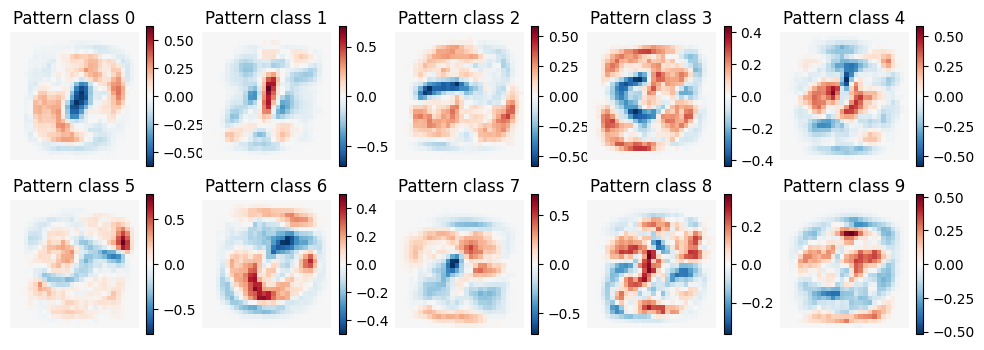

In [14]:
plt.figure(figsize=(12, 4))
for ind, pattern in enumerate(linear_model.weights.detach().numpy()):
    plt.subplot(2, 5, ind+1)
    absmax = abs(pattern).max()
    plt.imshow(pattern.reshape(28, 28), vmin=-absmax, vmax=absmax, cmap="RdBu_r")
    plt.axis("off")
    plt.colorbar()
    plt.title("Pattern class {}".format(ind))
plt.show()

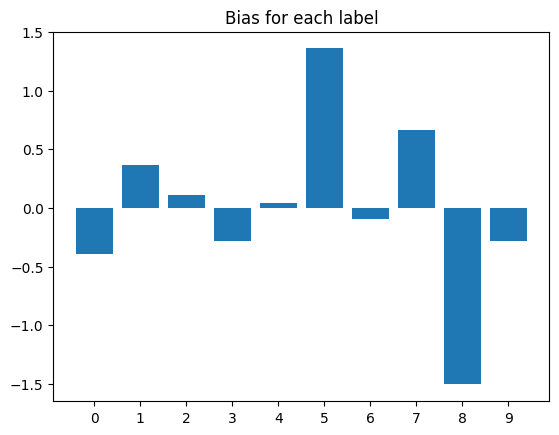

In [15]:
plt.bar(np.arange(10), linear_model.bias.detach().numpy())
plt.xticks(np.arange(10))
plt.title("Bias for each label")
plt.show()

# Deep Model

## Model Construction

In [16]:
def log_softmax(inputs: torch.tensor) -> torch.tensor:
    return inputs - torch.logsumexp(inputs, dim=1, keepdims=True)

def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

# Turns Logits into Probabilities
def softmax(inputs: torch.tensor) -> torch.tensor:
    exponential = torch.exp(inputs)
    return exponential / exponential.sum(axis=-1, keepdims=True)

# Error / Loss Function - Comparing output with Labels
def cross_entropy(labels: torch.tensor,
                  outputs: torch.tensor) -> torch.tensor:
    labels_one_hot = one_hot(labels, num_classes=10)
    return -(labels_one_hot * torch.log(outputs)).sum(axis=-1).mean()

# Evaluation Metric
def accuracy(labels: torch.tensor,
             outputs: torch.tensor) -> torch.tensor:
    predictions = torch.argmax(outputs, axis=-1)
    matches = labels == predictions
    return matches.float().mean()

# one hot - only one class can be hot (1)
# Converts a list of labels into a one hot encoded tensor.
# Corresponding to number of classes where the class is a 1.
# [0, 2, 1]
# [ [1, 0, 0]
#   [0, 0, 2]
#   [0, 1, 0]]
# Needed for label comparisons/Loss functions
def one_hot(inputs: torch.tensor, num_classes: Optional[int] = None) -> torch.tensor:
    if num_classes is None:
        num_classes = inputs.max() + 1
    output = torch.zeros(inputs.shape[0], num_classes)
    output.scatter_(1, inputs.view(-1, 1), torch.ones(inputs.shape[0], 1))

    return output

In [17]:
# Deep Model with Hidden Layers and Nodes as argument
class DeepModel:

  def __init__(self, input_size, layer_sizes):

    #layer_sizes = [20, 10]

    self.layers = []

    for size in layer_sizes:
        self.layers.append([
            torch.distributions.Uniform(-0.01, 0.01).sample((size, input_size)).requires_grad_(),  # weights
            torch.distributions.Uniform(-0.01, 0.01).sample((size,)).requires_grad_()  # bias
        ])
        input_size = size

  def forward(self, inputs: torch.tensor) -> torch.tensor:
    for layer in self.layers[:-1]:
        logits = inputs @ layer[0].transpose(0, 1) + layer[1]
        logits = relu(logits)

        inputs = logits

    logits = inputs @ self.layers[-1][0].transpose(0, 1) + self.layers[-1][1]

    return softmax(logits)

  def __call__(self, inputs: torch.tensor) -> torch.tensor:
    return self.forward(inputs)

**Layer Dimensions**

1 Layer:
output=[batch_size,784]×[784,10]=[batch_size,10]

2 Layers:
hidden_output=inputs×hidden_weights+hidden_bias
logits=hidden_output×out_weights+out_bias
batch_size,784 x 784,10 = batch_size,10
batch_size,10 x 784,10 = error

so:
batch_size, 784 x 784, 128 = batch_size, 128
batch_size, 128 x 128,10 = batch_size, 10

784, 10  and 10,10 would theoretically match dims

**Activation Function**

Allows the Network to learn non linear, how?

When to choose which:

Rectified Linear Activation (ReLU)

Logistic (Sigmoid)

Hyperbolic Tangent (Tanh)


**Improvements to be made**

Improved Parameter setup

Better Evaluation - Neuron Activation, ROC Curve

Different Metrics: Pre Class, F1-Score


## Model Training

In [18]:
def train_deep_model(model: DeepModel,
                       training_data: Tuple[np.ndarray, np.ndarray],
                       validation_data: Tuple[np.ndarray, np.ndarray],
                       learning_rate: float,
                       batch_size: int,
                       n_epochs: int,
                       validation_frequency: int = 1,
                       verbose: bool = True) -> Dict[str, np.ndarray]:
    n_training_examples = len(training_data[0])
    batches_per_epoch = n_training_examples // batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    random_shuffling = np.arange(n_training_examples)

    train_input_tensor = torch.tensor(training_data[0])
    train_label_tensor = torch.tensor(training_data[1])
    valid_input_tensor = torch.tensor(validation_data[0])
    valid_label_tensor = torch.tensor(validation_data[1])

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")
        start_time = perf_counter()
        # every epoch we shuffle the data!
        np.random.shuffle(random_shuffling)  # this shuffles in place
        slice_index = 0
        shuffled_inputs = train_input_tensor[random_shuffling]
        shuffled_labels = train_label_tensor[random_shuffling]

        epoch_train_losses = []
        epoch_train_accuracies = []

        for batch_ind in range(batches_per_epoch):
            input_batch = shuffled_inputs[slice_index:slice_index+batch_size]
            label_batch = shuffled_labels[slice_index:slice_index+batch_size]
            # this is the core of model training!
            # all the other stuff is pretty much just providing data and recording metrics...
            # two lines "forward" to compute outputs and the loss
            output_batch = model(input_batch)
            batch_loss = cross_entropy(label_batch, output_batch)
            # and then backpropagate
            batch_loss.backward()
            with torch.no_grad():
              for layer in model.layers:
                for parameter in layer:
                    parameter.sub_(parameter.grad * learning_rate)
                    parameter.grad.zero_()


            batch_accuracy = accuracy(label_batch, output_batch)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

            slice_index += batch_size
        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        with torch.no_grad():
            val_output = model(valid_input_tensor)
            val_loss = cross_entropy(valid_label_tensor, val_output)
            val_accuracy = accuracy(valid_label_tensor, val_output)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}

In [19]:
deep_model = DeepModel(784, [20, 10])
metrics = train_deep_model(deep_model, (x_train, y_train), (x_valid, y_valid),
                             learning_rate=0.1, batch_size=128, n_epochs=15)

Running 15 epochs at 390 steps per epoch.
Starting epoch 1... Time taken: 0.3620154089999943 seconds
	Train/val loss: 1.0858972871914887 / 0.402410089969635
	Train/val accuracy: 0.6748798076923077 / 0.8907999992370605
Starting epoch 2... Time taken: 0.3516589030000006 seconds
	Train/val loss: 0.37653130506857846 / 0.306278258562088
	Train/val accuracy: 0.8935697115384615 / 0.9126999974250793
Starting epoch 3... Time taken: 0.34758118000000593 seconds
	Train/val loss: 0.3190670719322486 / 0.27651551365852356
	Train/val accuracy: 0.909354967948718 / 0.9190000295639038
Starting epoch 4... Time taken: 0.3484072490000045 seconds
	Train/val loss: 0.28967248980815596 / 0.25909051299095154
	Train/val accuracy: 0.9182291666666667 / 0.9258000254631042
Starting epoch 5... Time taken: 0.38765801299999225 seconds
	Train/val loss: 0.2698484231073123 / 0.2409408986568451
	Train/val accuracy: 0.9235576923076924 / 0.930899977684021
Starting epoch 6... Time taken: 0.4593471790000052 seconds
	Train/val l

## Model Evaluation

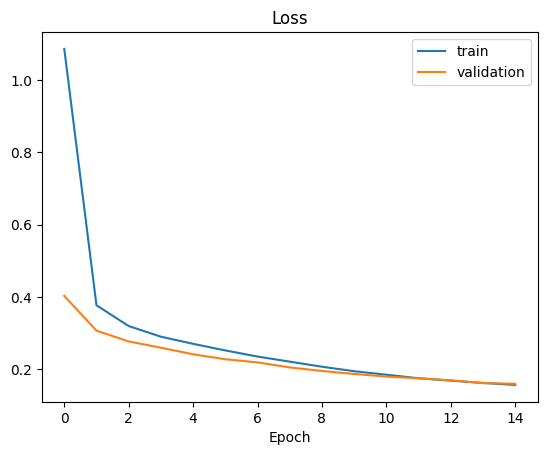

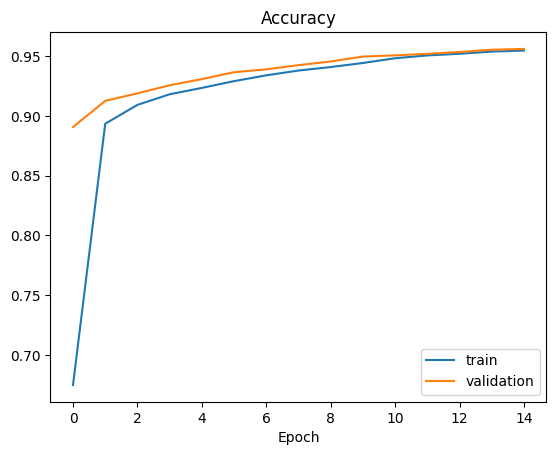

In [20]:
plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["val_loss"], label="validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(metrics["train_accuracy"], label="train")
plt.plot(metrics["val_accuracy"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [21]:
def confusion_matrix(inputs: np.ndarray,
                     labels: np.ndarray,
                     num_classes: Optional[int] = None) -> np.ndarray:
    if num_classes is None:
        num_classes = labels.max().item() + 1

    matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    with torch.no_grad():
        train_predictions = torch.argmax(deep_model(torch.tensor(inputs).to(device)), axis=-1).cpu().numpy()
    for class_index in range(num_classes):
        predictions_for_this_class = train_predictions[labels == class_index]
        for class_index_column in range(num_classes):
            count = len(np.where(predictions_for_this_class == class_index_column)[0])
            matrix[class_index, class_index_column] = count

    return matrix

training_matrix = confusion_matrix(x_train, y_train)
np.set_printoptions(suppress=True)
print("Training confusion matrix")
print(training_matrix)

validation_matrix = confusion_matrix(x_valid, y_valid)
print()
print("Validation confusion matrix")
print(validation_matrix)

Training confusion matrix
[[4787    1    8    7    8   35   30    7   36   13]
 [   1 5541   29   13    9   10    1   14   43   17]
 [  14   25 4664   38   51   14   24   55   66   17]
 [   9   13   69 4764    5  107   13   50   36   35]
 [   3    5   13    1 4715    4   16    5   10   87]
 [  15    5   13   26   12 4350   31    7   20   27]
 [  20    9   11    2   25   53 4817    0   13    1]
 [   4   14   28    9   41    7    2 5000    4   66]
 [  11   32   12   50   27   60   27    7 4553   63]
 [  13   13    3   30  125   13    1   54   21 4715]]

Validation confusion matrix
[[ 961    0    3    0    2    6    8    4    4    3]
 [   0 1043    4    3    2    1    0    1    8    2]
 [   2    5  933    6    9    3    4   13   12    3]
 [   4    2   11  964    2   21    1    5   15    5]
 [   0    5    0    0  952    2    4    1    1   18]
 [   4    1    6    8    5  863   14    3    6    5]
 [   3    1    7    0    4    4  947    0    1    0]
 [   1    4    4    5    3    0    0 1057  

In [22]:
for class_index in range(10):
    recall_train = training_matrix[class_index, class_index] / training_matrix[class_index].sum()
    precision_train = training_matrix[class_index, class_index] / training_matrix[:, class_index].sum()

    recall_valid = validation_matrix[class_index, class_index] / validation_matrix[class_index].sum()
    precision_valid = validation_matrix[class_index, class_index] / validation_matrix[:, class_index].sum()

    print("Class", class_index)
    print("Training recall", recall_train)
    print("Training precision", precision_train)
    print("Validation recall", recall_valid)
    print("Validation precision", precision_valid)
    print()

Class 0
Training recall 0.9706001622060016
Training precision 0.9815460323969654
Validation recall 0.9697275479313825
Validation precision 0.9796126401630989

Class 1
Training recall 0.9758717858400845
Training precision 0.9793213149522799
Validation recall 0.9802631578947368
Validation precision 0.9765917602996255

Class 2
Training recall 0.9388083735909822
Training precision 0.9616494845360825
Validation recall 0.9424242424242424
Validation precision 0.9588900308324769

Class 3
Training recall 0.9339345226426191
Training precision 0.9643724696356275
Validation recall 0.9359223300970874
Validation precision 0.9582504970178927

Class 4
Training recall 0.9703642724840502
Training precision 0.9396173774412117
Validation recall 0.9684638860630722
Validation precision 0.9425742574257425

Class 5
Training recall 0.9653794940079894
Training precision 0.9348807221147647
Validation recall 0.9431693989071038
Validation precision 0.9390642002176278

Class 6
Training recall 0.9729347606544132
Tra

### Model Behaviour

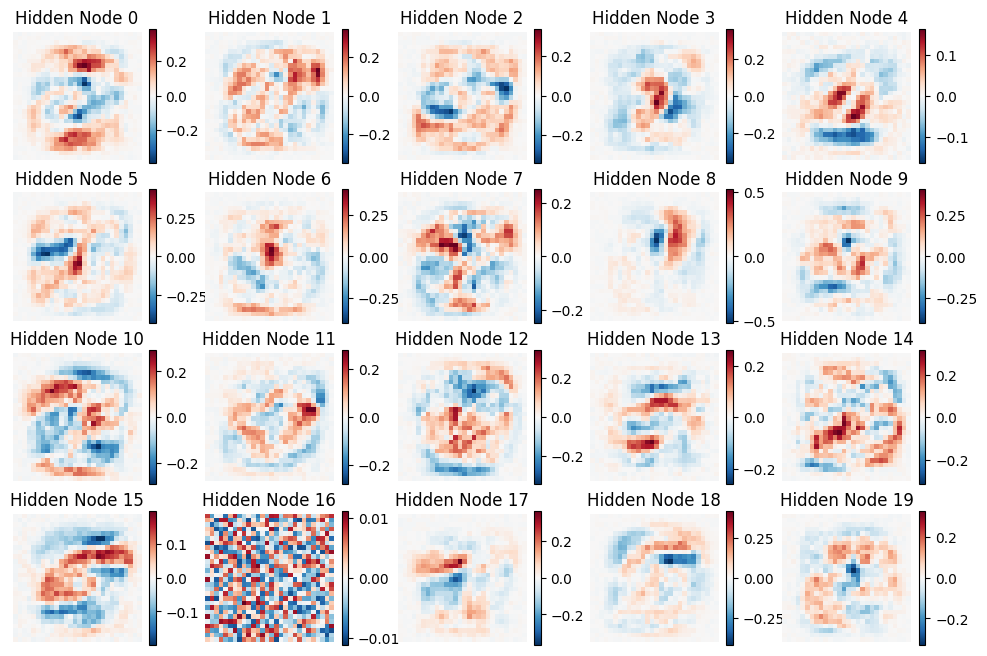

In [23]:
plt.figure(figsize=(12, 8))
for ind, pattern in enumerate(deep_model.layers[0][0].detach().cpu().numpy()):
    plt.subplot(4, 5, ind+1)
    absmax = abs(pattern).max()
    plt.imshow(pattern.reshape(28, 28), vmin=-absmax, vmax=absmax, cmap="RdBu_r")
    plt.axis("off")
    plt.colorbar()
    plt.title("Hidden Node {}".format(ind))
plt.show()

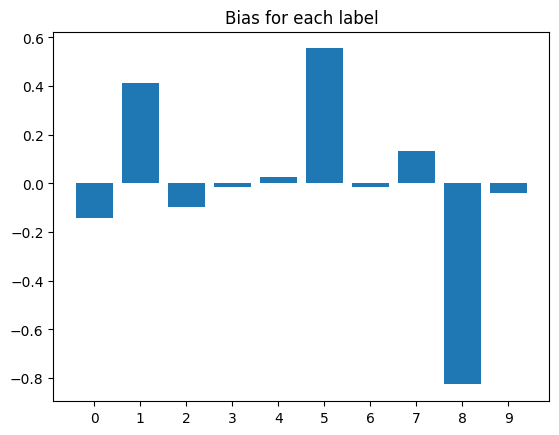

In [24]:
plt.bar(np.arange(10), deep_model.layers[1][1].detach().numpy())
plt.xticks(np.arange(10))
plt.title("Bias for each label")
plt.show()

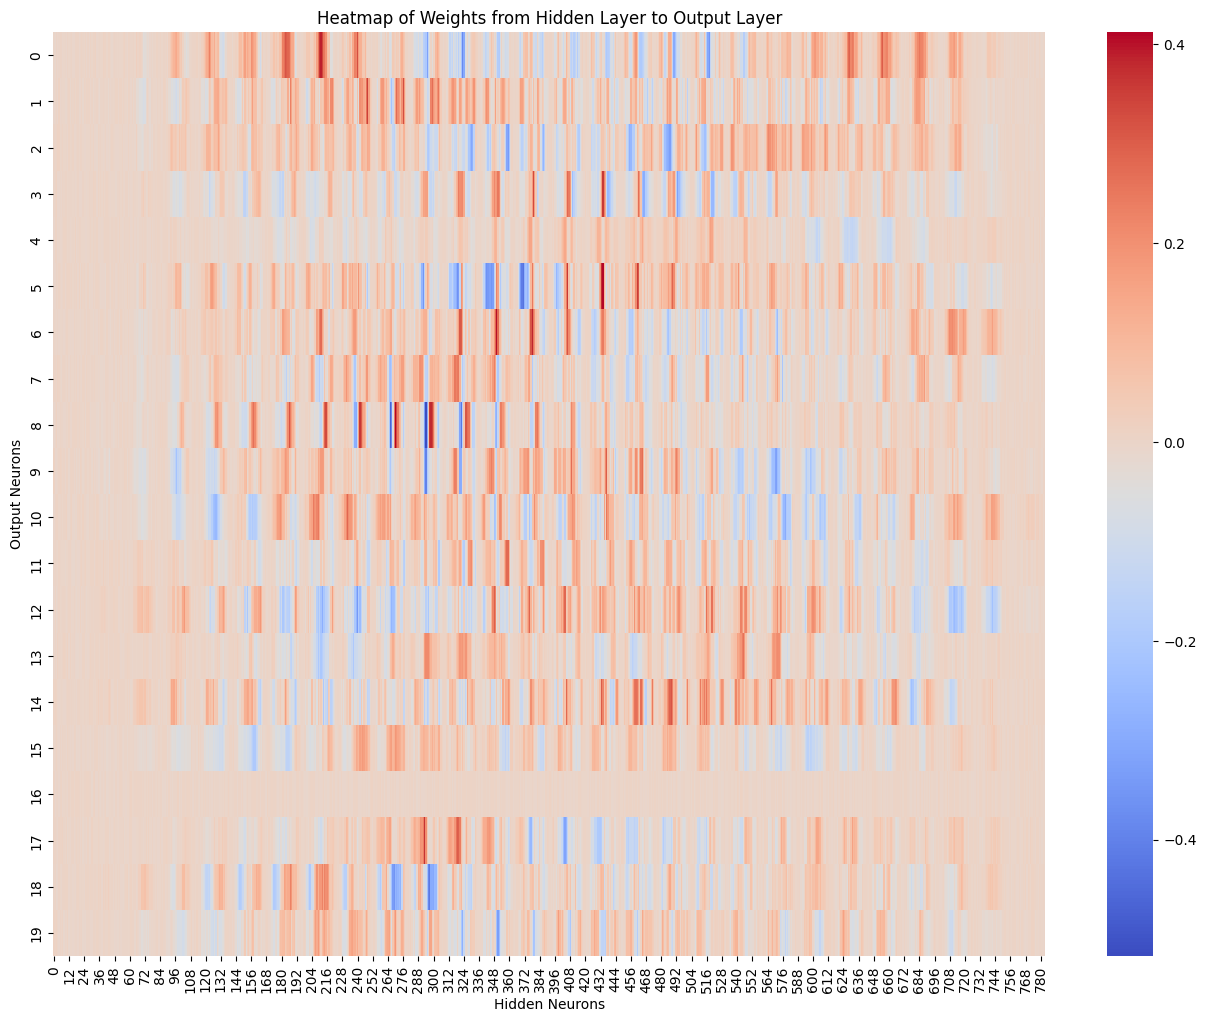

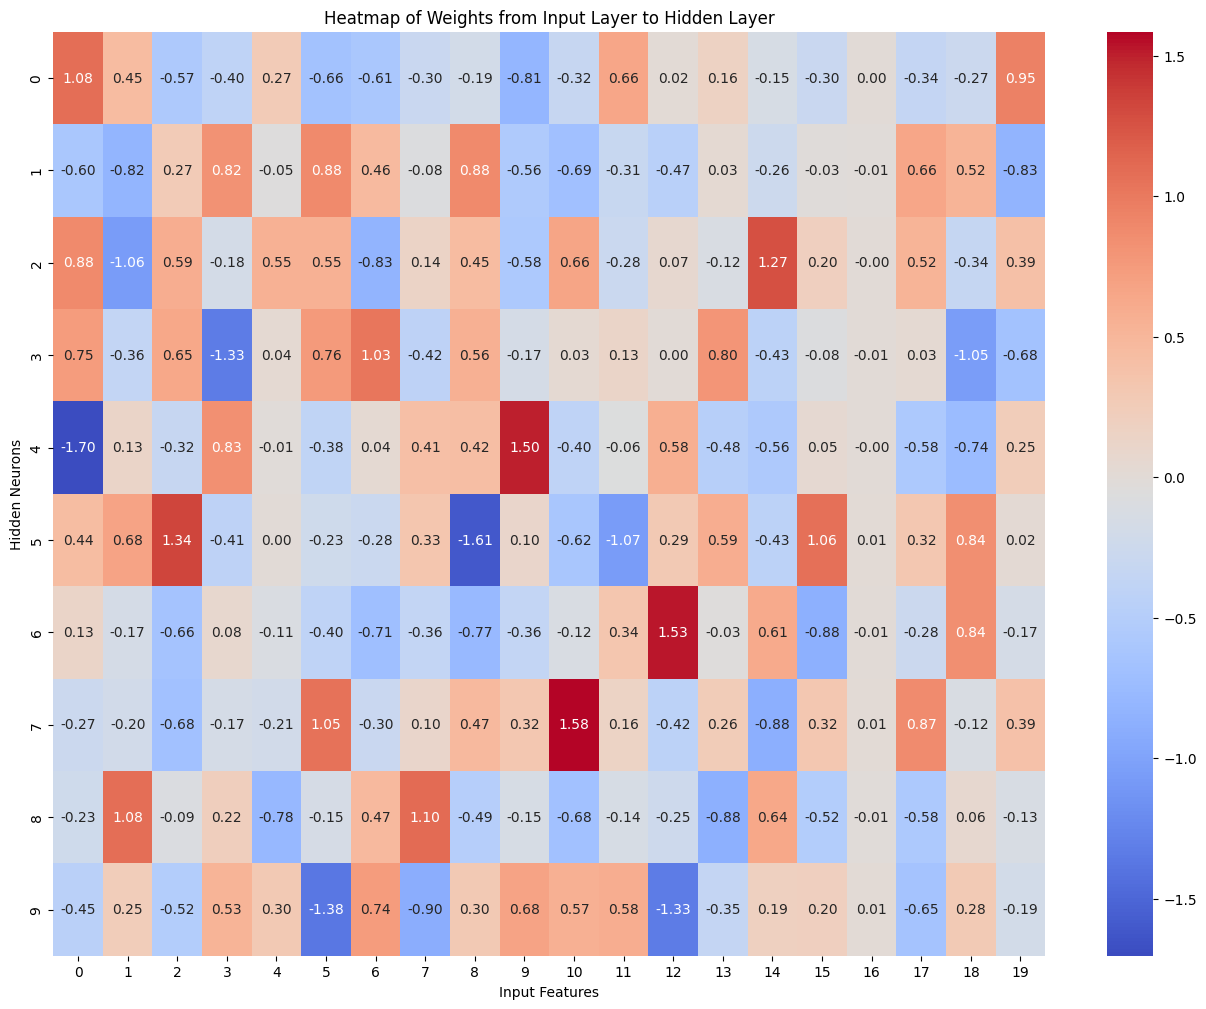

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming model is already defined
def visualize_weights(model):
    # Visualize the weights from hidden layer to output layer
    input_to_hidden_weights = model.layers[0][0].detach().numpy()  # (2, 50)
    plt.figure(figsize=(16, 12))
    sns.heatmap(input_to_hidden_weights, annot=False, cmap='coolwarm', fmt='.2f')
    plt.title('Heatmap of Weights from Hidden Layer to Output Layer')
    plt.xlabel('Hidden Neurons')
    plt.ylabel('Output Neurons')
    plt.show()

    # Visualize the weights from input layer to hidden layer
    hidden_to_out_weights = model.layers[1][0].detach().numpy()  # (50, 10)
    plt.figure(figsize=(16, 12))
    sns.heatmap(hidden_to_out_weights, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Heatmap of Weights from Input Layer to Hidden Layer')
    plt.xlabel('Input Features')
    plt.ylabel('Hidden Neurons')
    plt.show()

# Example usage
visualize_weights(deep_model)

# Comparison Basic Linear Model and Deep Model

# Hyperparameter Case Study

Accuracy
Convergence Speed
Stability - Vanishing/Exploding Gradients

Sparsity or Neuron activity?

**Hyperparameters**

Batch size, LR, Epochs
Number of Hidden Units
Optimizer?

In [26]:
# Function that creates a Model with different Parameter and traing it then saves the Results and later displays them

# Define the Layer Configurations to be tests
layer_configs = [[20, 10],
                [30, 10],
                [40, 10],
                [50, 10],
                [60, 10],
                [70, 10],
                [80, 10],
                [90, 10],
                [100, 10],
                [150, 10],
                [196, 10],
                [40, 20, 10],
                [60, 30, 10],
                [80, 40, 10],
                [100, 50, 10],
                [120, 60, 10],
                [80, 40, 20, 10]]

summary_metrics = []

# Iterate the configs and try each
for config in layer_configs:

  print(config)
  model = DeepModel(784, config)
  metrics = train_deep_model(model, (x_train, y_train), (x_valid, y_valid),
                             learning_rate=0.1, batch_size=128, n_epochs=15)

  summary_metrics.append({"config": config, "metrics": metrics})

[20, 10]
Running 15 epochs at 390 steps per epoch.
Starting epoch 1... Time taken: 0.3723453449999994 seconds
	Train/val loss: 1.0805361767609913 / 0.3961872458457947
	Train/val accuracy: 0.6791266025641025 / 0.8903999924659729
Starting epoch 2... Time taken: 0.37723397400000636 seconds
	Train/val loss: 0.37494863997667266 / 0.3053629398345947
	Train/val accuracy: 0.8936698717948718 / 0.9156000018119812
Starting epoch 3... Time taken: 0.36191305199999135 seconds
	Train/val loss: 0.31730729463772894 / 0.2770134210586548
	Train/val accuracy: 0.9092748397435897 / 0.9222000241279602
Starting epoch 4... Time taken: 0.3726698879999901 seconds
	Train/val loss: 0.2876524787682753 / 0.2552107274532318
	Train/val accuracy: 0.9174879807692308 / 0.9304999709129333
Starting epoch 5... Time taken: 0.37237217599999894 seconds
	Train/val loss: 0.2660806474204247 / 0.24551434814929962
	Train/val accuracy: 0.9240985576923076 / 0.9330999851226807
Starting epoch 6... Time taken: 0.36386219800000674 second

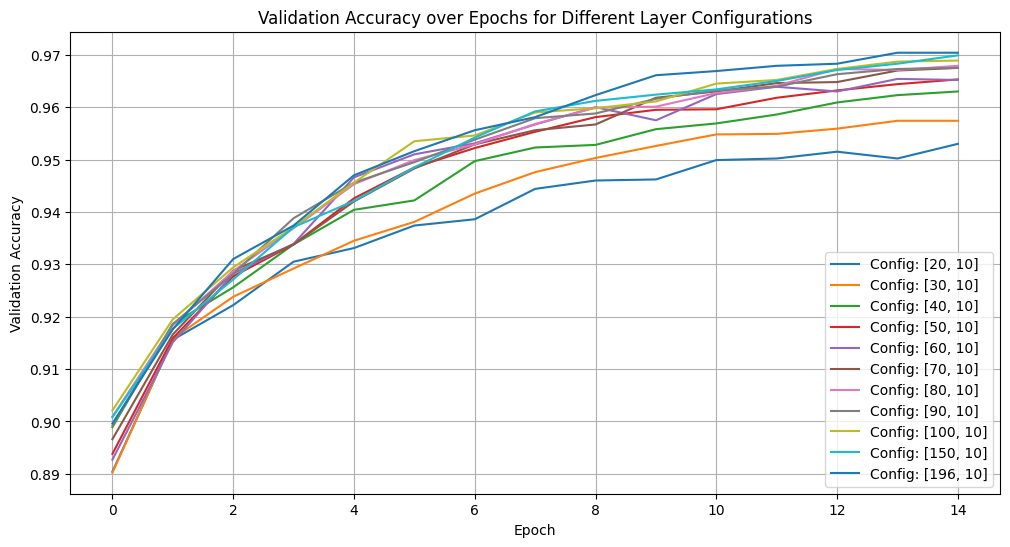

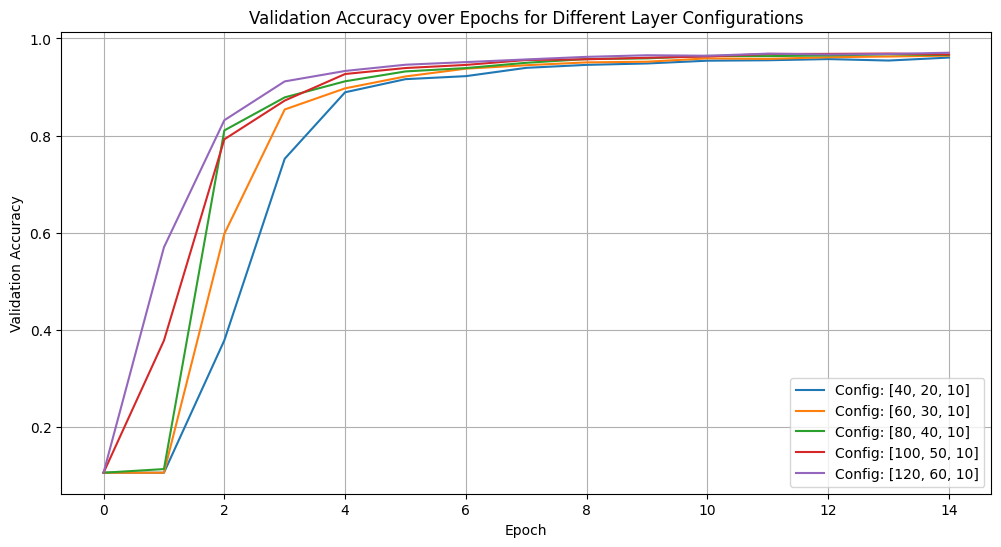

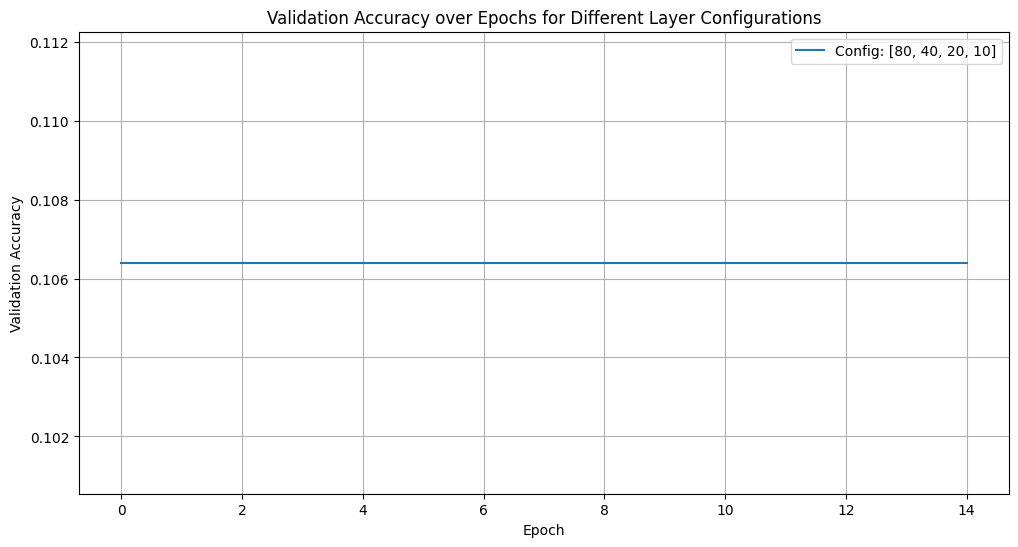

In [27]:
# 2 Layer plot
plt.figure(figsize=(12, 6))

for result in summary_metrics:
    config = result["config"]
    if(len(config) != 2):
      continue
    val_acc = result["metrics"]["val_accuracy"]
    plt.plot(val_acc, label=f"Config: {config}")

    #plt.text(len(val_acc)-1, val_acc[-1], f'{val_acc[-1]:.2f}', color='red', fontsize=10, ha='right')  # Display the value


plt.title("Validation Accuracy over Epochs for Different Layer Configurations")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

plt.legend()
plt.grid(True)

plt.show()

# 3 Layer plot
plt.figure(figsize=(12, 6))

for result in summary_metrics:
    config = result["config"]
    if(len(config) != 3):
      continue
    val_acc = result["metrics"]["val_accuracy"]
    plt.plot(val_acc, label=f"Config: {config}")

plt.title("Validation Accuracy over Epochs for Different Layer Configurations")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

plt.legend()
plt.grid(True)

plt.show()

# 4 Layer plot
plt.figure(figsize=(12, 6))

for result in summary_metrics:
    config = result["config"]
    if(len(config) != 4):
      continue
    val_acc = result["metrics"]["val_accuracy"]
    plt.plot(val_acc, label=f"Config: {config}")

plt.title("Validation Accuracy over Epochs for Different Layer Configurations")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")

plt.legend()
plt.grid(True)

plt.show()

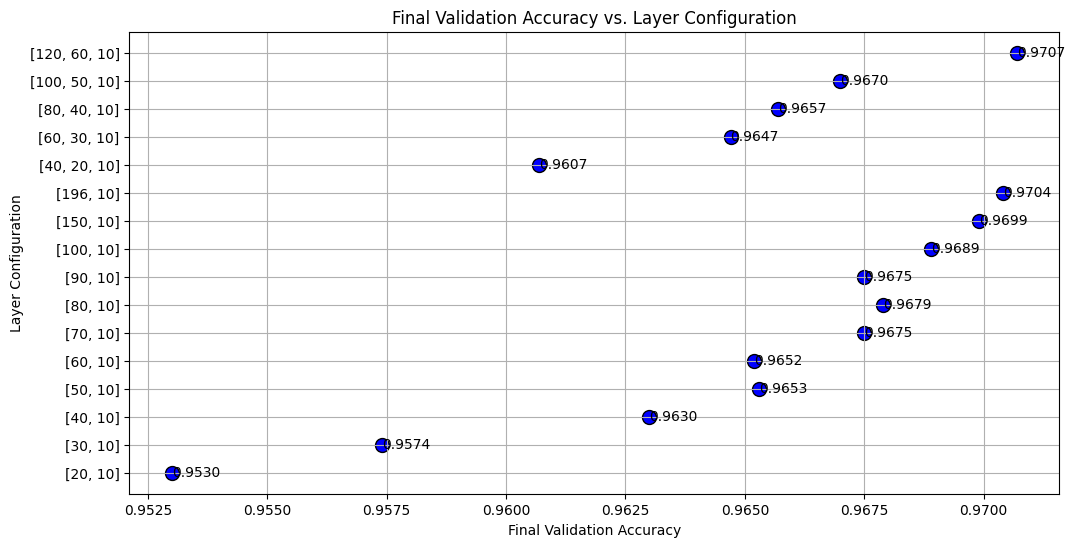

In [28]:
# Prepare lists to hold the layer configurations and final validation accuracies
layer_configs = []
final_val_accuracies = []

# Loop through the configurations in summary_metrics
for result in summary_metrics:
    config = result["config"]

    # Only continue if config has the desired length (e.g., length 3)
    if len(config) > 3:
        continue

    # Get the final validation accuracy
    val_acc = result["metrics"]["val_accuracy"]
    final_val_acc = val_acc[-1]

    # Append data for plotting
    layer_configs.append(str(config))  # Convert config to string for display
    final_val_accuracies.append(final_val_acc)

# Plotting Validation Accuracy vs. Layer Configurations
plt.figure(figsize=(12, 6))
plt.scatter(final_val_accuracies, layer_configs, color='blue', s=100, edgecolors='black')  # Scatter plot

# Add the exact final validation accuracy next to each point
for i, final_acc in enumerate(final_val_accuracies):
    plt.text(final_val_accuracies[i], layer_configs[i], f'{final_acc:.4f}', fontsize=10, ha='left', va='center')

# Title and labels
plt.title("Final Validation Accuracy vs. Layer Configuration")
plt.xlabel("Final Validation Accuracy")
plt.ylabel("Layer Configuration")

# Grid for better readability
plt.grid(True)
plt.show()

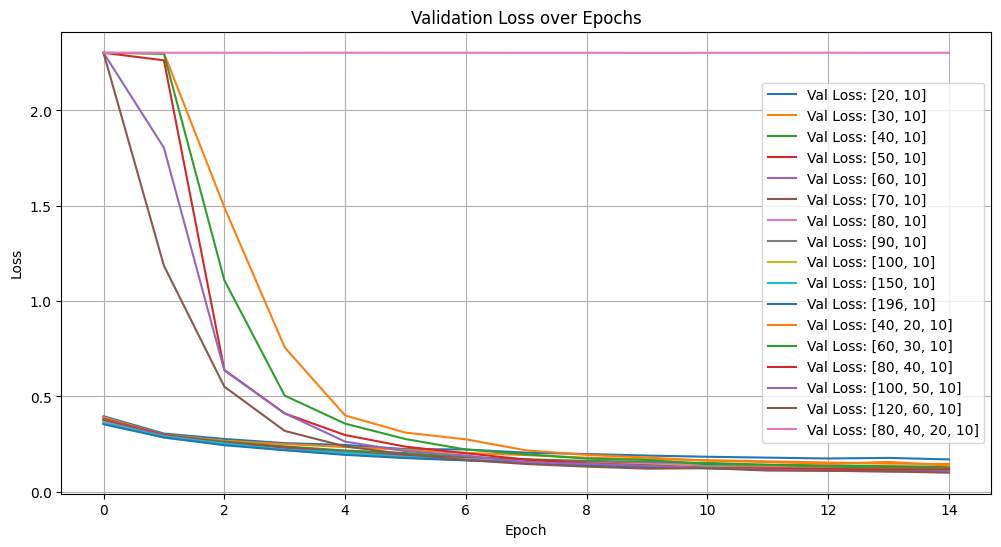

In [29]:
plt.figure(figsize=(12, 6))
for result in summary_metrics:
    config = result["config"]
    val_loss = result["metrics"]["val_loss"]
    plt.plot(val_loss, label=f"Val Loss: {config}")
plt.title("Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Assignment 1.5

## Backpropagation

## Data

Dataset stores the samples and their corresponding labels

DataLoader wraps an iterable around the Dataset

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.1MB/s]

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


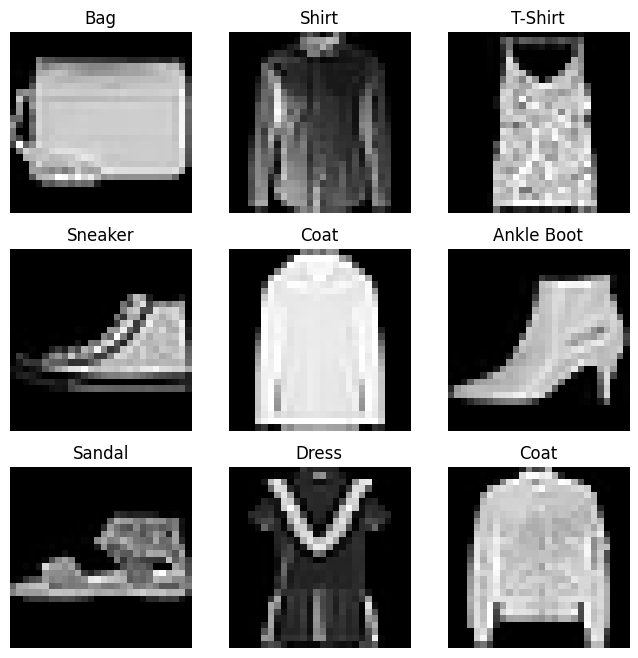

In [42]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Custom Dataset

We initialize the directory containing the images, the annotations file, and both transforms

The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

#### Summary

We specify where the Images and Labels are located and a function to get an image with corresponding label at a given index


In [44]:
import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


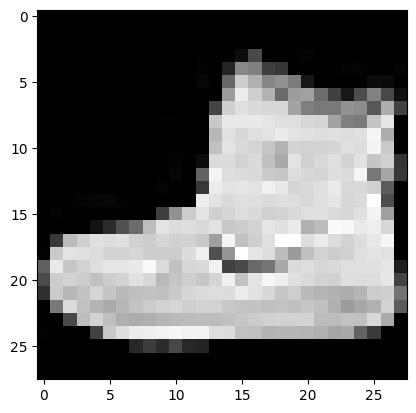

Label: 9


In [45]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms.

transforms to perform some manipulation of the data and make it suitable for training

transform to modify the features and target_transform to modify the labels



## Model

To accelerate operations in the neural network, we move it to the accelerator such as CUDA. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

create a class that inherits from nn.Module

define the layers of the network in the __init__ function

specify how data will pass through the network in the forward function



In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing Parameters

Loss function & Optimizer

In a single training loop, the model makes predictions on the training dataset (fed to it in batches),
 and backpropagates the prediction error to adjust the model’s parameters.

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [36]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [37]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [38]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312852  [   64/60000]
loss: 2.293195  [ 6464/60000]
loss: 2.281385  [12864/60000]
loss: 2.270769  [19264/60000]
loss: 2.245512  [25664/60000]
loss: 2.243495  [32064/60000]
loss: 2.232319  [38464/60000]
loss: 2.205119  [44864/60000]
loss: 2.209291  [51264/60000]
loss: 2.181087  [57664/60000]
Test Error: 
 Accuracy: 56.6%, Avg loss: 2.172323 

Epoch 2
-------------------------------
loss: 2.183492  [   64/60000]
loss: 2.172074  [ 6464/60000]
loss: 2.121967  [12864/60000]
loss: 2.134471  [19264/60000]
loss: 2.072585  [25664/60000]
loss: 2.041670  [32064/60000]
loss: 2.054162  [38464/60000]
loss: 1.980488  [44864/60000]
loss: 1.990265  [51264/60000]
loss: 1.920795  [57664/60000]
Test Error: 
 Accuracy: 58.9%, Avg loss: 1.920028 

Epoch 3
-------------------------------
loss: 1.951687  [   64/60000]
loss: 1.923956  [ 6464/60000]
loss: 1.815270  [12864/60000]
loss: 1.847823  [19264/60000]
loss: 1.729518  [25664/60000]
loss: 1.695503  [32064/600

## Saving & Loading Model

In [39]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [40]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [41]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
